## Información integrantes del equipo de trabajo
**Nombre y apellidos (Grupo): Elodie Curcio**

**Nombre y apellidos (Grupo): Guillermo Díaz**

**Nombre y apellidos (Grupo): Miguel Quiroga**

# Dinámica molecular


Para estudiar la dinámica molecular de un fluido o un gas mediante simulaciones podemos resolver las ecuaciones en derivadas totales

$$ m_i\frac{d^2\vec{r}_i(t)}{dt^2} = \vec{F}_i(t)\, ,$$

donde $i$ hace referencia a la partícula $i$-ésima, $\vec{r}_i(t)$ es el vector posición de la partícula en el instante $t$, $m_i$ la mása de la partícula, y $\vec{F}_i(t)$ la fuerza total que siente la partícula a causa de todas las demás en el instante $t$. Definido un potencial de interacción podemos calcular la fuerza. En nuestro caso consideremos el potencial de Lennard-Jones:

$$V(d) = 4\epsilon\left[\left(\frac{\sigma}{d}\right)^{12}-\left(\frac{\sigma}{d}\right)^6\right]\, ,$$

donde $d$ es la distancia entre las partículas,$\epsilon$ la magnitud del mínimo, y $\sigma$ se relaciona con el tamaño efectivo de las partículas. A partir de este potencial, tenemos que

$$\vec{F}_i = -\vec{\nabla}V_i = \sum_{j\neq i} 4\epsilon\left[12\frac{\sigma^{12}}{d_{i,j}^{13}}-6\frac{\sigma^6}{d_{i,j}^7}\right]\hat{r}_{i\rightarrow j}\, ,$$

siendo $\hat{r}_{i\rightarrow j}$ el vector unitario en la dirección $i\rightarrow j$ que conecta las partículas.

## Apartado a:

- Considere una partícula que se mueve dentro de una caja de tamaño L=1 cuadrada en dos dimensiones. Considerar condiciones de contorno fijas (pared rígida). Para ello resolved numéricamente el sistema de ecuaciones diferenciales, por un método numérico. Representad la posición de la partícula a lo largo del tiempo en el plano $XY$. Considerar rebotes elásticos. **EXTRA** Probad a añadir gravedad al problema de una sola partícula.

In [1]:
# Librerías

from numpy import linspace, array, zeros, arange, ndarray, where, fill_diagonal, meshgrid, cos, sin, save, load, mean, exp
from numpy.linalg import norm
from numpy.random import normal, random
from math import pi, ceil
from pylab import plot, show, scatter, xlabel, ylabel, axis, vlines, hlines, xlim, ylim, title, legend, hist


In [2]:
def f(r: ndarray, gravity: float, potentialCalc: bool = False) -> tuple[ndarray, ndarray] | ndarray:
    """
    Función de evolución de todas las partículas.

    Inputs
    ------
    r : ndarray (size `[particles, 2]`)
        Posiciones y velocidades de todas las partículas para un único tiempo.
    gravity : float
        Magnitud de la gravedad en el eje `y`.
    potentialCalc : bool
        En caso `True`, la función devolverá también el potencial de cada partícula (ver sección `Outputs`).

    Outputs
    -------
    fun : ndarray (size `[particles, 4]`)
        Contiene los elementos de la función de evolución de las partículas.
    finalPotential : ndarray (size `[particles]`)
        (solo si `potentialCalc == True`) Potencial sentido por cada partícula.
    """
    particles = r.shape[0]
    xPos = r[:, 0]
    yPos = r[:, 1]
    xVel = r[:, 2]
    yVel = r[:, 3]
    fun = zeros([particles, 4], float)
    fun[:, 0] = xVel
    fun[:, 1] = yVel
    if potentialCalc:
        fun[:, 2:], potential = force(r, gravity, potentialCalc)
        return fun, potential # early return para evitar más cálculos
    fun[:, 2:] = force(r, gravity, False)
    return fun

def force(r: ndarray, gravity: float, potentialCalc: bool) -> tuple[ndarray, ndarray] | ndarray:
    """
    Calcula la fuerza en todas las partículas para un único tiempo.

    Inputs
    ------
    r : ndarray (size `[particles, 2]`)
        Posiciones y velocidades de todas las partículas para un único tiempo.
    gravity : float
        Magnitud de la gravedad en el eje `y`.
    potentialCalc : bool
        En caso `True`, la función devolverá también el potencial de cada partícula (ver sección `Outputs`).

    Outputs
    -------
    finalForce : ndarray (size `[particles, 2]`)
        Ambas componentes de la fuerza para cada partícula.
    finalPotential : ndarray (size `[particles]`)
        (solo si `potentialCalc == True`) Potencial sentido por cada partícula.
    """
    particles = r.shape[0]
    finalForce = zeros([particles, 2], float)

    global sigma, epsilon, tol, mass

    # Calculamos las distancias relativas y los vectores relativos
    particleRel = zeros([particles, particles, 2], float)
    for i in range(particles):
        particleRel[i, :, :] = r[:, 0:2]
    particleRelPos = zeros([particles, particles], float)
    particleRelPos = ((particleRel[:,:,0] - particleRel[:,:,0].T)**2 + (particleRel[:,:,1] - particleRel[:,:,1].T)**2)**0.5 # this should be illegal, but it really works

    fill_diagonal(particleRelPos, float('inf')) # ignoramos la diagonal (interacciones entre la misma partícula)

    particleRelVec = zeros([particles, particles, 2], float)
    particleRelVec[:, :, 0] = (particleRel[:,:,0]-particleRel[:,:,0].T) / -particleRelPos
    particleRelVec[:, :, 1] = (particleRel[:,:,1]-particleRel[:,:,1].T) / -particleRelPos

    particleRelPos = where(particleRelPos < tol, tol, particleRelPos) # para evitar fuerzas muy altas

    particleForce = zeros([particles, particles, 2], float)
    particleForce[:,:,0] = 4*epsilon * ( 12*sigma**12/particleRelPos**13 - 6*sigma**6/particleRelPos**7 ) * particleRelVec[:,:,0]
    particleForce[:,:,1] = 4*epsilon * ( 12*sigma**12/particleRelPos**13 - 6*sigma**6/particleRelPos**7 ) * particleRelVec[:,:,1]
    
    if float(gravity) != 0.0:
        finalForce[:, 1] -= gravity

    if potentialCalc:
        finalPotential = zeros([particles], float)
        potential = 4*epsilon * ( (sigma/particleRelPos)**12 - (sigma/particleRelPos)**6 )
        for i in range(particles):
            finalPotential[i] = sum(potential[i,:])
            finalForce[i,0] += sum(particleForce[i,:,0])
            finalForce[i,1] += sum(particleForce[i,:,1])
        return finalForce/mass, finalPotential # early return para evitar más cálculos

    for i in range(particles):
        finalForce[i,0] += sum(particleForce[i,:,0])
        finalForce[i,1] += sum(particleForce[i,:,1])

    return finalForce/mass


def partEvolve(r: ndarray, timeMax: float, timeStep: float, boxSize: float, gravity: float = 0.0) -> tuple[ndarray, ndarray, ndarray]: # aka rungeKutta4
    """
    Cálculo de evolución de todas las partículas.

    Inputs
    ------
    r : ndarray
        Condiciones inciales de posiciones y velocidades de todas las partículas.
    timeMax : float
        Tiempo máximo para la simulación.
    timeStep : float
        Paso temporal de la simulación. En caso de errores, aumentar este parámetro.
    boxSize : float
        Tamaño de la caja que contiene las partículas. Centrada en `(0, 0)`.
    gravity : float, default: `0.0`
        Magnitud de la gravedad en el eje `y`.

    Outputs
    -------
    positions : ndarray (size `[particles, 2, timeSteps]`)
        Almacena todas las posiciones visitadas por las partículas durante la duración completa de la simulación.
    velocities : ndarray (size `[particles, 2, timeSteps]`)
        Almacena todas las velocidades de las partículas durante la duración completa de la simulación.
    potentials : ndarray (size `[particles, timeSteps]`)
        Almacena el potencial sentido por cada partícula en cada instante de tiempo.
    """
    time = arange(0,timeMax+timeStep, timeStep)
    particles = r.shape[0]
    positions = zeros([particles, 2, time.size], float)     # Pre-alocamos las posiciones
    velocities = zeros([particles, 2, time.size], float)    # Pre-alocamos las velocidades
    potentials = zeros([particles, time.size], float)       # Pre-alocamos las energías potenciales
    for i in range(time.size):
        # Asignación de velocidades y posiciones
        positions[:, 0, i] = r[:, 0]
        positions[:, 1, i] = r[:, 1]
        velocities[:, 0, i] = r[:, 2]
        velocities[:, 1, i] = r[:, 3]
        
        # Barra de progreso
        print(f"time = {round(time[i],2)}/{round(time[-1],2)} || procesando {' '*10}", end='\r')
        
        # Rugne-Kutta de cuarto orden
        k1, potentials[:, i] = f(r, gravity, True) # tan solo se calculan los potenciales aquí, para ahorrar tiempo de computación
        k2 = timeStep * f(r + timeStep * k1/2, gravity)
        k3 = timeStep * f(r + k2/2, gravity)
        k4 = timeStep * f(r + k3, gravity)
        r += (timeStep * k1 + 2*k2 + 2*k3 + k4) / 6

        # Verificación de fuera de límites
        r[:, 2] = where(abs(r[:,0]) >= boxSize/2, -r[:, 2], r[:, 2])    # Eje x
        r[:, 3] = where(abs(r[:,1]) >= boxSize/2, -r[:, 3], r[:, 3])    # Eje y

    # Barra de progreso
    print(f"time = {round(time[i],2)}/{round(time[-1],2)} || completado {' '*10}", end='\r') # progreso
    return positions, velocities, potentials

def plotBox(boxSize: float):
    """
    Representa una caja del tamaño indicado centrada en (0,0).

    Inputs
    ------
    boxSize : float
        Tamaño de la caja que contiene las partículas. Centrada en `(0, 0)`.
    """
    vlines(boxSize/2,-boxSize/2,boxSize/2,'k')  # límites verticales
    vlines(-boxSize/2,-boxSize/2,boxSize/2,'k') #
    hlines(boxSize/2,-boxSize/2,boxSize/2,'k')  # límites horizontales
    hlines(-boxSize/2,-boxSize/2,boxSize/2,'k') #
    xlim([-boxSize/2, boxSize/2])
    ylim([-boxSize/2, boxSize/2])
    xlabel('$x$ (m)')
    ylabel('$y$ (m)')
    axis('equal')

def plotParticles(positions: ndarray):
    """
    Representa la trayectoria de todas las partículas.

    Inputs
    ------
    positions : ndarray (size `[particles, 2, timeSteps]`)
        Array con las posiciones de las partículas de la simulación.

    Notas
    -----
    El input de esta función se puede obtener mediante `partEvolve`.
    """
    particles = positions.shape[0]
    for part in range(particles):
        plot(positions[part, 0, :], positions[part, 1, :])


In [3]:
# Variables globales
boxSize = 1
mass = 1
# sigma = 0.015
# epsilon = 0.4
sigma = 0.01
epsilon = 0.5
tol = 0.01
timeStep = 1e-4

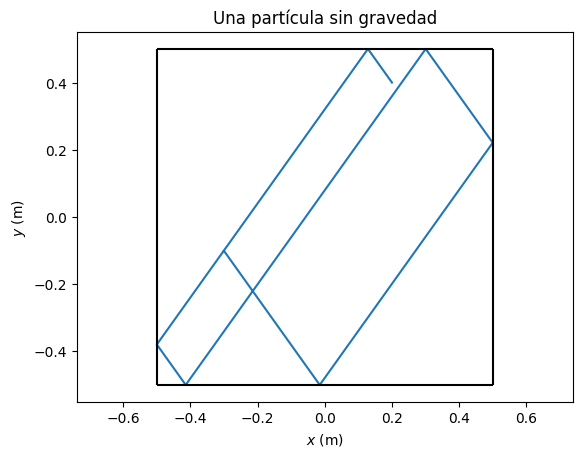

In [4]:
r = zeros([1, 4], float)
r[0,:] = array([0.2, 0.4, -0.5, 0.7], float)
timeMax = 5
timeStep = 1e-3
positions = partEvolve(r, timeMax, timeStep, boxSize, gravity = 0.0)[0]
plotParticles(positions)
plotBox(boxSize)
title('Una partícula sin gravedad')
show()

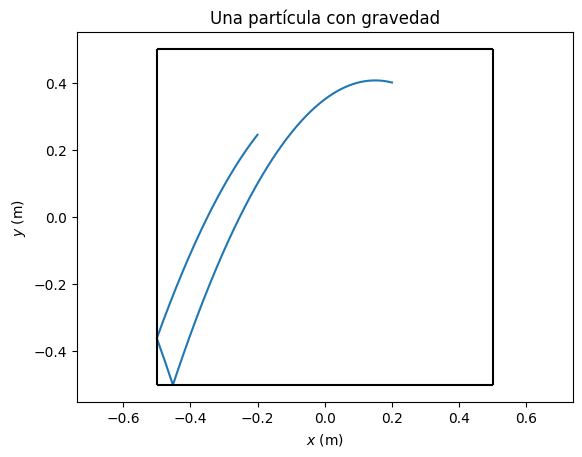

In [5]:
r = zeros([1, 4], float)
r[0,:] = array([0.2, 0.4, -0.2, 0.05], float)
timeMax = 5
timeStep = 1e-3
positions = partEvolve(r, timeMax, timeStep, boxSize, gravity = 0.2)[0]
plotParticles(positions)
plotBox(boxSize)
title('Una partícula con gravedad')
show()

# NOTA: la gravedad también se puede añadir al problema de N partículas.

- Incluir una segunda partícula interactuante al problema. Representar la posición de las dos particulas en el plano $XY$, así como la evolución de cada coordenada en el tiempo.  Tomad $\epsilon\sim0.5$ y $\sigma\sim0.01$. **AYUDA** Empezad considerando particulas no interactuantes y luego añadir la interacción. Posicionar las dos partículas y darles velocidades iniciales tales que colisionen para comprobar que la interacción se lleva acabo correctamente.

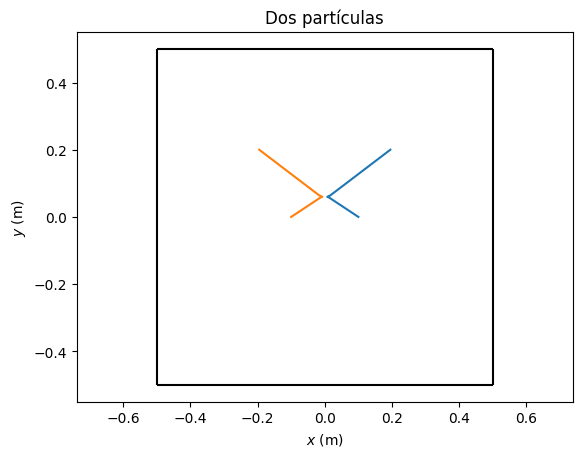

In [6]:
particles = 2
timeMax = 1
timeStep = 1e-3

r = zeros([particles, 4], float) # inicializa posiciones y velocidades
r[0,0], r[0,2], r[0,3] = 0.1, -0.3, 0.2
r[1,0], r[1,2], r[1,3] = -0.1, 0.3, 0.2

positions = partEvolve(r, timeMax, timeStep, boxSize, gravity = 0.0)[0]

plotParticles(positions)
plotBox(boxSize)
title('Dos partículas')
show()


- Generalizar el programa para considerar $N$ partículas. **CONSEJOS**:
    - Se recomienda tener una matriz que contenga toda la información de las partículas $[(x_i,y_i,v^{(x)}_i,v^{(y)}_i)]$.
    - Empezad considerando pocas particulas e id aumentando el numero de ellas.
    - En el cálculo de la fuerza de interacción, puede darse que dos partículas estén muy juntas, de forma que la aceleración que sienten es muy grande. Se recomienda usar un "cut_off", el cual puede consistir en la transformación $r_{ij}<tol\rightarrow r_{ij}=tol$, donde es recomendable tomar $tol\sim 0.01$ (puede ser necesario ajustar el valor de $tol$ según los valores exactos de $\sigma$ y $\epsilon$ tomados. Para ello se recomienda representar la fuerza en función de la distancia para los valores tomados).
    - Para determinar las posiciones iniciales, es aconsejable crear una cuadrícula centrada en la caja y posicionar las partículas en los nodos de la misma. Para esto pueden ser útiles la función ``mesgrid`` y ``flatten`` de ``numpy``.
    - Para las velocidades, se recomienda generar de forma aleatoria un ángulo que determine la dirección y el módulo del vector velocidad para cada partícula. Este último se recomienda generarlo con una distribución gaussiana, de média 0.5 y desviación 0.1.
    - Cuantas más partículas consideremos, menor debe ser el $\Delta t$ para evitar "perdernos" colisiones. Esto implica que necesitaremos hacer más iteraciones para representar el mismo periodo de tiempo. Se recomienda ir ajustando el numero de partículas, el $\Delta t$ y el número de iteraciones poco a poco, empezando por valores razonables y nunca considerando cantidades demasiado grandes).
    - Posiblemente, la simulación final (con mayor cantidad de partículas, por ejemplo, 100-200, y más larga) tarde un tiempo en ejecutarse. Una vez generados esos datos, se recomienda escribirlos en un fichero para facilitar el resto del trabajo.

In [6]:
def randomStart(particles: int, boxSize: float, wallSep = 'Auto', velMean: float = 0.5, velStd: float = 0.1) -> ndarray:
    """
    Coloca `particles` cantidad de partículas en una cuadrícula dentro de la caja. Asigna velocidades aleatorias.

    Inputs
    ------
    particles : int
        Número de particulas a inicializar.
    boxSize : float
        Tamaño de la caja que contiene las partículas. Centrada en `(0, 0)`.
    wallSep : float o `'Auto'`, default: `'Auto'`
        Separación mínima a la pared de la caja.
    velMean : float, default: `0.5`
        Velocidad media de las partículas.
    velStd : float, default: `0.1`
        Desviación estándar de la distribución gaussiana de velocidades.

    Outputs
    -------
    r : ndarray (size `[particles, 4]`)
        Contiene las posiciones y velocidades generadas de todas las partículas.
    """
    r = zeros([particles, 4], float)

    gridRes = ceil(particles**0.5) # cantidad de puntos en cada dimensión de la cuadrícula
    
    if wallSep == 'Auto':
        wallSep = boxSize/(gridRes+1)

    x = linspace(-boxSize/2+wallSep, boxSize/2-wallSep, gridRes)
    y = linspace(-boxSize/2+wallSep, boxSize/2-wallSep, gridRes)
    x, y = meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()

    r[:,0] = x[:particles]
    r[:,1] = y[:particles]

    angle = random(particles)*2*pi
    velMod = abs(normal(velMean, velStd, particles))
    r[:,2] = cos(angle)*velMod
    r[:,3] = sin(angle)*velMod

    return r

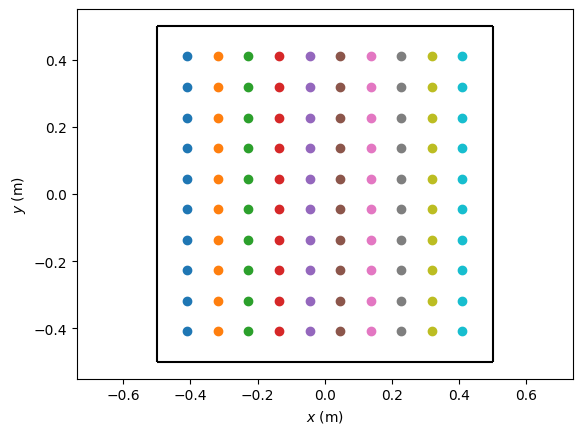

In [7]:
particles = 100
r = randomStart(particles, 1, 'Auto')
for i in range(particles):
    scatter(r[i,0], r[i,1])
plotBox(1)

In [8]:
particles = 100
timeMax = 4
timeStep = 1e-4
"""
r = randomStart(particles, boxSize, 'Auto')

positions, velocities, potentials = partEvolve(r, timeMax, timeStep, boxSize)

save('positions', positions)
save('velocities', velocities)
save('potentials', potentials)
"""

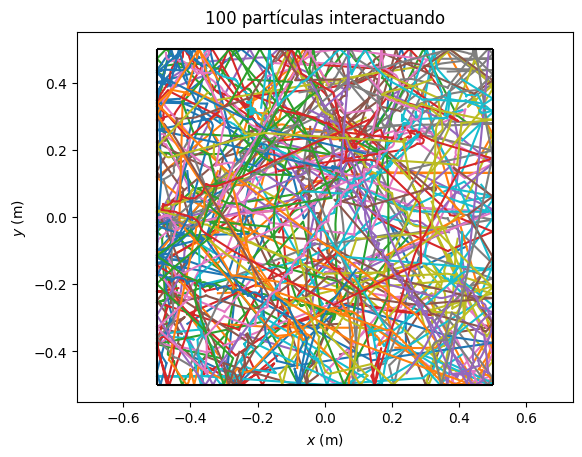

In [9]:
positions = load('positions.npy')
plotParticles(positions)
plotBox(boxSize)
title(f'{particles} partículas interactuando')
show()

## Apartado b:

- Usando las posiciones y velocidades del último 10% de las iteraciones realizadas en la simulación, calculad la energía cinética, potencial y total del sistema a lo largo del tiempo y representarlas en un gráfico.

In [10]:
def energy(velocities: ndarray, potentials: ndarray, start: float = 0.0, end: float = 1.0, plots: str = '111') -> tuple[ndarray, ndarray, ndarray]:
    """
    Calcula la energía cinética , potencial de Lennard-Jones y total del sistema de partículas.

    Inputs
    ------
    velocities : ndarray (size `[particles, 2, timeSteps]`)
        Las velocidades de las partículas durante la duración completa de la simulación.
    potentials : ndarray (size `[particles, timeSteps]`)
        Potencial sentido por cada partícula en cada instante de tiempo.
    start : float, default: `0.0`. min: `0.0`
        Fracción de iteraciones a partir de la cual calcular las energías.
    end : float, default: `1.0`. max: `1.0`
        Fracción de iteraciones hasta la cual calcular las energías.
    plots : str, default: `'111'`
        Cada íncide indica si añadir las respectivas energías a la representación final. `'100'`: cinética. `'010'`: potencial. `'001'`: total.

    Outputs
    -------
    energyKin : ndarray
        Array con las energías cinéticas totales en cada iteración.
    energyPot : ndarray
        Array con las energías potenciales totales en cada iteración.
    energyTot : ndarray
        Array con las energías totales totales en cada iteración.
    """
    indexHigh = int(velocities.shape[2]*end)
    indexLow = int(velocities.shape[2]*start)

    global mass
    energyPot = sum(potentials[:,indexLow:indexHigh])
    energyKin = 1/2 * mass * sum( norm(velocities[:,:,indexLow:indexHigh], axis=1) )
    energyTot = energyKin + energyPot

    if plots[0] == '1':
        plot(energyKin, label='Energía cinética')
    if plots[1] == '1':
        plot(energyPot, label='Energía potencial')
    if plots[2] == '1':
        plot(energyTot, label='Energía total')
    if '1' in plots:
        legend()
        xlabel('Iteraciones')
        ylabel('$E$ (J)')
        title(f'Energías del {round(start*100)}% al {round(end*100)}% de iteraciones')
        show()
    return energyKin, energyPot, energyTot

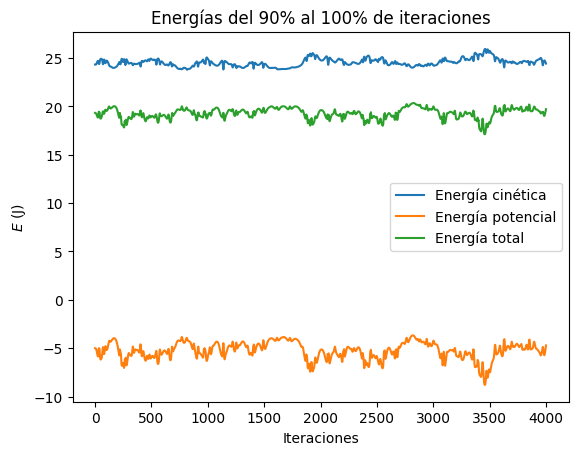

In [11]:
velocities = load('velocities.npy')
potentials = load('potentials.npy')

energyKin, energyPot, energyTot = energy(velocities, potentials, 0.9, plots = '111')


- Haced un histograma del módulo de las velocidades a lo largo del último 10% de las iteraciones para todas las partículas y superponer la función de distribución teórica:

$$p(v) = \frac{v}{K_BT}e^{-v^2/2K_BT}\, ,$$

donde el valor de $K_BT$ se puede estimar a partir de la energía cinética média por partícula haciendo uso del Teorema de equipartición (recordad que el sistema es de dos dimensiones). **AYUDA** En caso de que los datos no ajusten muy bien a la curva, puede ser por que no se ha hecho una simulación suficientemente larga y por tanto no se a alcanzado el equilibrio térmico.

In [12]:
def velProb(v: float | ndarray, energyKin: float, particles: int) -> float | ndarray:
    """
    Calcula la probabilidad teórica para cada velocidad extrayendo la temperatura del sistema a partir del teorema de equipartición.

    Inputs
    ------
    v : float or ndarray
        Velocidad o rango de velocidades.
    energyKin : float
        Energía cinética total del sistema para deducir la temperatura.
    particles : int
        Número de partículas del sistema para deducir la temperatura.

    Outputs
    -------
    prob : float or ndarray
        Probabilidades calculadas según la distribución `p(v) = v/K_BT · e^{-v^2/2K_BT}` (distribución Maxwell-Boltzmann).

    Notas
    -----
    El teorema de equipartición indica que cada grado de libertad de una partícula contribuye con `kT/2` a la energía total.

    Por tanto, sabiendo que estamos en dos dimensiones, la energía total es `E = kT · particles`, debido a los dos grados de libertad traslacionales.
    """
    kT = energyKin/particles
    prob = v/kT * exp( -v**2/(2*kT) )
    return prob


def histVel(velocities: ndarray, start: float = 0.0, end: float = 1.0):
    """
    Representa el histograma de velocidades de cada partícula, superponiendo la distribución de Maxwell-Boltzmann.

    Inputs
    ------
    velocities : ndarray (size `[particles, 2, timeSteps]`)
        Las velocidades de las partículas durante la duración completa de la simulación.
    start : float, default: `0.0`. min: `0.0`
        Fracción de iteraciones a partir de la cual calcular las energías.
    end : float, default: `1.0`. max: `1.0`
        Fracción de iteraciones hasta la cual calcular las energías.
    """
    indexHigh = int(velocities.shape[2]*end)
    indexLow = int(velocities.shape[2]*start)

    global mass
    velMod = norm(velocities[:,:,indexLow:indexHigh], axis=1)
    energyKin = 1/2 * mass * sum( velMod )
    velMod = velMod.flatten()

    v = linspace(velMod.min(), velMod.max(), 100)
    probVel = velProb(v, mean(energyKin), velocities.shape[0])
    hist(velMod, density=True, bins=20)
    plot(v, probVel)
    xlabel('$v$ (m/s)')
    ylabel('Frecuencia')
    title('Histograma del módulo de las velocidades')
    show()

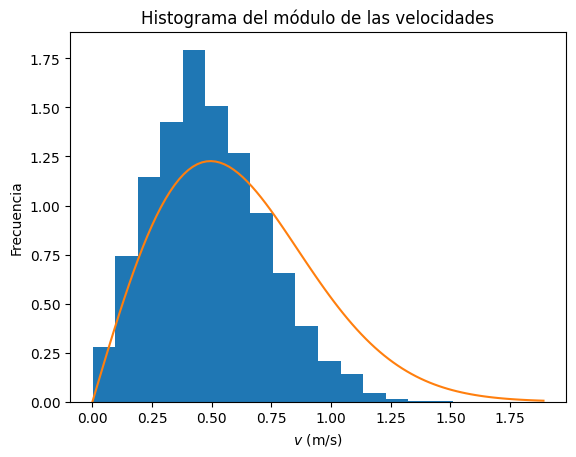

In [13]:
histVel(velocities)

#### Conclusión apartado b)
En este último gráfico podemos observar que la simulación no se ajusta a la perfección a la distribución de Maxwell-Boltzmann, aunque sí se observa que no tiene un comportamiento gaussiano, cual era lo esperado. La razón por la que no encaja bien con la distribución es posible que sea la duración de la simulación, que no permite que todas las partículas lleguen a equilibrio térmico.

## Apartado c:

- Repetid la simulación considerando una velocidad media nula y una desviacion de 0.25. Repedid el apartado b para estos nuevos datos. ¿Qué conclusiones podéis sacar?

In [ ]:
particles = 100
timeMax = 4
timeStep = 1e-4
"""
r = randomStart(particles, 1, 'Auto', 0.0, 0.25)

positions2, velocities2, potentials2 = partEvolve(r, timeMax, timeStep, boxSize)

save('positions2', positions2)
save('velocities2', velocities2)
save('potentials2', potentials2)
"""

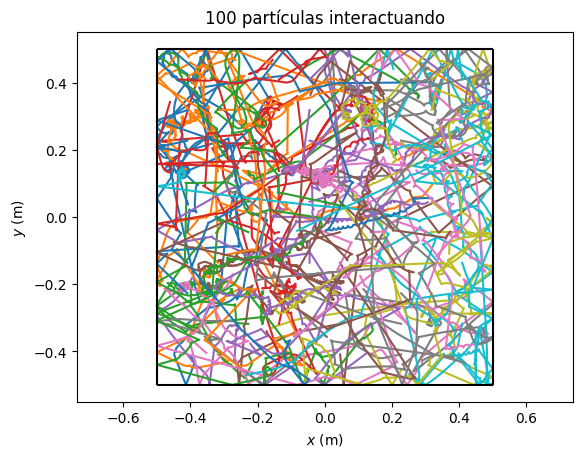

In [16]:
positions2 = load('positions2.npy')
plotParticles(positions2)
plotBox(boxSize)
title(f'{particles} partículas interactuando')
show()

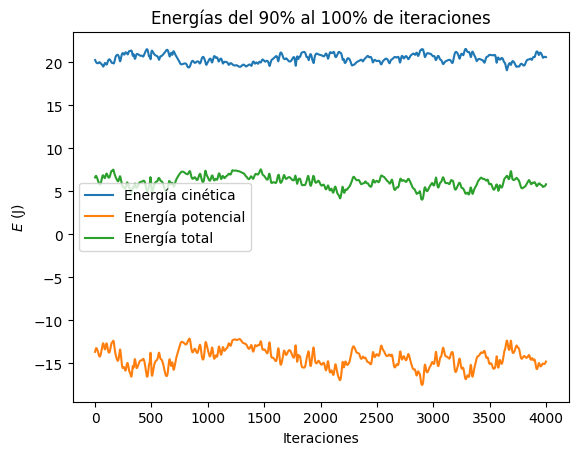

In [17]:
velocities2 = load('velocities2.npy')
potentials2 = load('potentials2.npy')

energyKin, energyPot, energyTot = energy(velocities2, potentials2, start = 0.9, plots = '111')

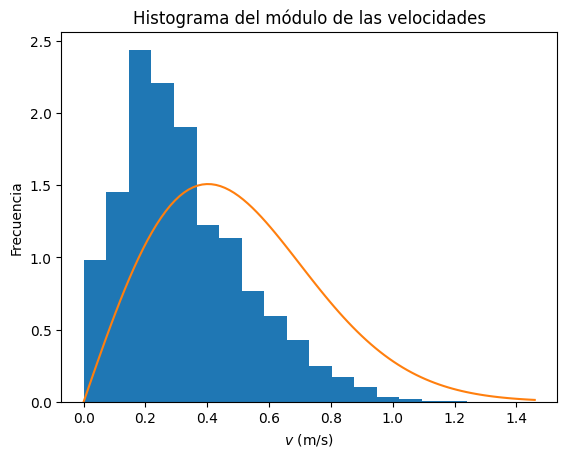

In [18]:
histVel(velocities2)

#### Conclusión apartado c)
Al dejar la simulación correr la misma cantidad de tiempo que antes alterando las velocidades, vemos que los datos se ajustan peor a la distribución esperada. Esto puede ser debido a la menor velocidad media de las partículas, que hace que tarden mucho más en alcanzar el equilibrio térmico.

Pese a esto, es evidente que la distribución de las velocidades no es gaussiana como fueron inicialmente asignadas. La distribución a la que tienden es aquella de Maxwell-Boltzmann que se superpone en el gráfico.
